Epoch 1 完成
Epoch 2 完成
Epoch 3 完成
Epoch 4 完成
Epoch 5 完成

测试准确率：0.9749


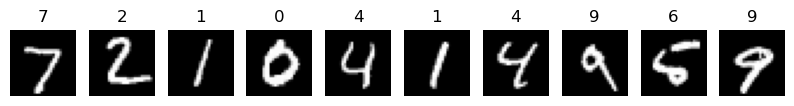

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 定义一个简单的CNN模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 加载 MNIST 数据集
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练模型
for epoch in range(1, 6):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} 完成")

# 测试模型
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

print(f"\n测试准确率：{correct / len(test_loader.dataset):.4f}")

# 显示前10个预测结果
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    output = model(example_data.to(device))

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"{output[i].argmax().item()}")
    plt.axis('off')
plt.show()

我们来测试代码，学习 pytorch 结构：

In [2]:
import numpy as np

# 获取模型参数的state_dict
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('fc1.weight', tensor([[ 0.0318, -0.0292, -0.0084,  ...,  0.0133,  0.0329,  0.0178],
        [ 0.0050, -0.0201,  0.0306,  ..., -0.0080, -0.0135, -0.0205],
        [ 0.0218, -0.0209,  0.0109,  ...,  0.0172,  0.0168, -0.0250],
        ...,
        [ 0.0037, -0.0272, -0.0038,  ..., -0.0168,  0.0204, -0.0265],
        [ 0.0351, -0.0256,  0.0347,  ...,  0.0347,  0.0197,  0.0091],
        [ 0.0225,  0.0207, -0.0129,  ...,  0.0114, -0.0295, -0.0269]])), ('fc1.bias', tensor([-0.1444, -0.1129,  0.0851, -0.1721,  0.1727,  0.0529,  0.0270, -0.0336,
        -0.0752,  0.1973, -0.0830,  0.0211, -0.1648, -0.1104,  0.1270,  0.1370,
        -0.0428, -0.0369,  0.1456,  0.0994,  0.0875,  0.0627,  0.2011, -0.0648,
         0.1523, -0.0023,  0.0733,  0.1009,  0.0040, -0.2162,  0.0817,  0.0684,
        -0.0190, -0.0911,  0.1429, -0.1360,  0.0677, -0.1961,  0.0906, -0.1851,
         0.1394, -0.1317, -0.0513,  0.0534,  0.0406,  0.0094, -0.0972,  0.1118,
         0.0875,  0.1329,  0.0753,  0.0505,

从中不难分析出，我们需要的数据都是以 dictionary 的形式，即 (key, value) 的形式存储。我们真正需要的参数就是 `fc1.weight`, `fc1.bias`, `fc2.weight`, `fc2.bias`:

In [3]:
W1 = state_dict['fc1.weight']
b1 = state_dict['fc1.bias']
W2 = state_dict['fc2.weight']
b2 = state_dict['fc2.bias']

我们可以记录下来，再输出：

In [4]:
print (W1)

tensor([[ 0.0318, -0.0292, -0.0084,  ...,  0.0133,  0.0329,  0.0178],
        [ 0.0050, -0.0201,  0.0306,  ..., -0.0080, -0.0135, -0.0205],
        [ 0.0218, -0.0209,  0.0109,  ...,  0.0172,  0.0168, -0.0250],
        ...,
        [ 0.0037, -0.0272, -0.0038,  ..., -0.0168,  0.0204, -0.0265],
        [ 0.0351, -0.0256,  0.0347,  ...,  0.0347,  0.0197,  0.0091],
        [ 0.0225,  0.0207, -0.0129,  ...,  0.0114, -0.0295, -0.0269]])


检查它的值和属性：

In [5]:
W1.shape

torch.Size([128, 784])

在阅读了 AI 的解释之后，我们可以将上述参数直接转成 numpy 的数组，然后存储起来。在这个过程中，我们不想拉平数组（`flatten()`），也不想将所有参数集中为一个数组（`np.concatenate([...])`），我们尝试保存所有参数的数组结构，并以二进制文件的形式存储。以便于后续我们用其他语言读出，再直接在内存中形成数组。

In [6]:
W1.numpy()

array([[ 0.03184346, -0.02924388, -0.00843849, ...,  0.01333205,
         0.03294464,  0.01777283],
       [ 0.00499205, -0.0200829 ,  0.03063413, ..., -0.00802872,
        -0.01346813, -0.02045709],
       [ 0.02176846, -0.02087042,  0.01093082, ...,  0.01723282,
         0.01683863, -0.02498706],
       ...,
       [ 0.00374972, -0.02724724, -0.00383054, ..., -0.01684714,
         0.02035334, -0.02648209],
       [ 0.03508311, -0.02557291,  0.03466736, ...,  0.03474255,
         0.01968213,  0.00907661],
       [ 0.02253369,  0.02068593, -0.01287071, ...,  0.01138796,
        -0.0294566 , -0.02688707]], shape=(128, 784), dtype=float32)

In [7]:
W1np=W1.numpy()

In [8]:
W1np.tofile?

Docstring:
a.tofile(fid, sep="", format="%s")

Write array to a file as text or binary (default).

Data is always written in 'C' order, independent of the order of `a`.
The data produced by this method can be recovered using the function
fromfile().

Parameters
----------
fid : file or str or Path
    An open file object, or a string containing a filename.
sep : str
    Separator between array items for text output.
    If "" (empty), a binary file is written, equivalent to
    ``file.write(a.tobytes())``.
format : str
    Format string for text file output.
    Each entry in the array is formatted to text by first converting
    it to the closest Python type, and then using "format" % item.

Notes
-----
This is a convenience function for quick storage of array data.
Information on endianness and precision is lost, so this method is not a
good choice for files intended to archive data or transport data between
machines with different endianness. Some of these problems can be overcome
b

研究上面的文档，我们知道可以直接将一个 tensor 输出为一个二进制文件：

In [9]:
W1.numpy().astype(np.float32).tofile("W1.bin")

这里我们研究了一下具体 `tofile` 的具体用法，比如追加还是覆盖，然后自己实现一下将所有参数写到一个二进制文件 `parameters.bin` 中：

In [ ]:
W1 = state_dict['fc1.weight']
b1 = state_dict['fc1.bias']
W2 = state_dict['fc2.weight']
b2 = state_dict['fc2.bias']

# 用写模式保证清空旧文件
with open("parameters_mlp.bin", "wb") as out_bin:
    W1.numpy().astype(np.float32).tofile(out_bin)
    b1.numpy().astype(np.float32).tofile(out_bin)
    W2.numpy().astype(np.float32).tofile(out_bin)
    b2.numpy().astype(np.float32).tofile(out_bin)
